In [224]:
import pandas as pd
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import warnings
import random
import datashader
import datashader.transfer_functions
from datashader.utils import lnglat_to_meters
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from datashader.bokeh_ext import InteractiveImage
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader import transfer_functions as tr_fns
from bokeh.plotting import figure, output_notebook, show # bokeh plotting library
from matplotlib import cm
import shap
from lightgbm import LGBMRegressor
import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import clone
from sklearn.model_selection import check_cv
from category_encoders import CatBoostEncoder
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore')

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.style.use('bmh')
color_pal = [c for c in sns.color_palette('husl', n_colors=50)]
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plot_width = int(750)
plot_height = int(plot_width//1.2)

random.Random(1).shuffle(color_pal)

def calculatePercentage(df, slice_level='hour'):
    pivot = pd.pivot_table(df, 
                           index = slice_level,
                           columns = 'occupancy',
                           values = 'filename',
                           aggfunc = 'count'
                          )\
              .reset_index()\
              .fillna(0)

    pivot.iloc[:, 1:] = pivot.iloc[:, 1:].divide(pivot.iloc[:, 1:].sum(axis=1), axis=0)
    pivot.columns = [slice_level, 'Not Occupied', 'Occupied']
    return pivot

def base_plot(tools='pan, wheel_zoom, reset', plot_width=600, plot_height=600, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
              x_range=x_range, y_range=y_range, outline_line_color=None,
              min_border=0, min_border_left=0, min_border_right=0,
              min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(tripData, 'longitude_start', 'latitude_start', ds.count('occupancy'))
    img = tr_fns.shade(agg, cmap=cm.plasma, how='eq_hist')
    return tr_fns.dynspread(img, threshold=0.5, max_px=4)

# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

class TargetEncoderCV(BaseEstimator, TransformerMixin):
    '''
    Fold-based target encoder robust to overfitting
    '''

    def __init__(self, cv, **cbe_params):
        self.cv = cv
        self.cbe_params = cbe_params

    @property
    def _n_splits(self):
        return check_cv(self.cv).n_splits

    def fit_transform(self, X: pd.DataFrame, y) -> pd.DataFrame:
        self.cbe_ = []
        cv = check_cv(self.cv)
        cbe = CatBoostEncoder(
            cols=X.columns.tolist(),
            return_df=False,
            **self.cbe_params)

        X_transformed = np.zeros_like(X, dtype=np.float64)
        for train_idx, valid_idx in cv.split(X, y):
            self.cbe_.append(clone(cbe).fit(X.loc[train_idx], y[train_idx]))
            X_transformed[valid_idx] = self.cbe_[
                -1].transform(X.loc[valid_idx])
        return pd.DataFrame(X_transformed, columns=X.columns)

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_transformed = np.zeros_like(X, dtype=np.float64)
        for cbe in self.cbe_:
            X_transformed += cbe.transform(X) / self._n_splits
        return pd.DataFrame(X_transformed, columns=X.columns)

# Read data

In [4]:
dataPath = r'../data/cabspottingdata'

In [5]:
fileNames = [f for f in listdir(dataPath) if isfile(join(dataPath, f)) and 'txt' in f]

In [6]:
print('Number of files: ', len(fileNames))

Number of files:  537


In [7]:
df = pd.DataFrame({'latitude':[], 
                   'longitude':[], 
                   'occupancy':[], 
                   'time':[],
                   'filename':[]})

for fileName in tqdm(fileNames):
    chunk = pd.read_csv(join(dataPath, fileName), sep=' ', header=None)
    chunk['filename'] = fileName
    chunk.columns = df.columns
    df = df.append(chunk, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████| 537/537 [01:26<00:00,  6.22it/s]


In [8]:
df.head()

latitude  longitude  occupancy          time        filename
0  37.75153 -122.39447        0.0  1.211034e+09  new_abboip.txt
1  37.75149 -122.39447        0.0  1.211034e+09  new_abboip.txt
2  37.75149 -122.39447        0.0  1.211034e+09  new_abboip.txt
3  37.75149 -122.39446        0.0  1.211034e+09  new_abboip.txt
4  37.75144 -122.39449        0.0  1.211035e+09  new_abboip.txt

In [9]:
df.sort_values(by=['filename', 'time'], inplace=True)

In [10]:
# df.to_csv(join(dataPath, r'all_drivers.csv'), index=False)

In [11]:
df['next_time'] = df.groupby('filename')['time'].shift(-1)
df['next_latitude'] = df.groupby('filename')['latitude'].shift(-1)
df['next_longitude'] = df.groupby('filename')['longitude'].shift(-1)

In [12]:
df['dt'] = pd.to_datetime(df['time'],unit='s')

In [13]:
df['duration'] = df['next_time'] - df['time']
df['latitude_change'] = df['next_latitude'] - df['latitude']
df['longitude_change'] = df['next_longitude'] - df['longitude']

In [14]:
df['weekday_number'] = df['dt'].dt.weekday
df['weekday_name'] = df['dt'].dt.day_name()
df['weekday'] = df['weekday_number'].astype(str) + ' : ' + df['weekday_name']
df['week'] = df['dt'].dt.week
df['hour'] = df['dt'].dt.hour
df['week'] = df['dt'].dt.isocalendar().week

In [15]:
df.head()

latitude  longitude  occupancy          time        filename     next_time  next_latitude  next_longitude                  dt  duration  latitude_change  longitude_change  weekday_number weekday_name       weekday  week  hour
0  37.75153 -122.39447        0.0  1.211034e+09  new_abboip.txt  1.211034e+09       37.75149      -122.39447 2008-05-17 14:12:10      84.0         -0.00004           0.00000               5     Saturday  5 : Saturday    20    14
1  37.75149 -122.39447        0.0  1.211034e+09  new_abboip.txt  1.211034e+09       37.75149      -122.39447 2008-05-17 14:13:34      60.0          0.00000           0.00000               5     Saturday  5 : Saturday    20    14
2  37.75149 -122.39447        0.0  1.211034e+09  new_abboip.txt  1.211034e+09       37.75149      -122.39446 2008-05-17 14:14:34      61.0          0.00000           0.00001               5     Saturday  5 : Saturday    20    14
3  37.75149 -122.39446        0.0  1.211034e+09  new_abboip.txt  1.211035e+09       37.75144      -122.39449 2008-05-17 14:15:35    1568.0         -0.00005          -0.00003               5     Saturday  5 : Saturday    20    14
4  37.75144 -122.39449        0.0  1.211035e+09  new_abboip.txt  1.211035e+09       37.75151      -122.39453 2008-05-17 14:41:43      71.0          0.00007          -0.00004               5     Saturday  5 : Saturday    20    14

# EDA

## Initial dataset

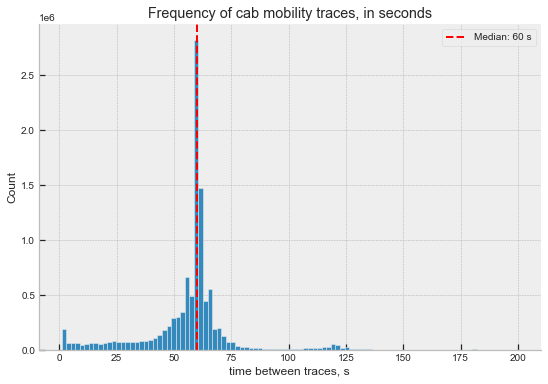

In [483]:
plt.figure(figsize=(9, 6))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("time between traces, s")  
plt.ylabel("Count")  

plt.hist(df[df['duration'] <= 200]['duration'], bins=100)  
plt.axvline(x=df['duration'].median(), label='Median: {0:0.0f} s'.format(df['duration'].median()), 
            linestyle='--', c='red')
plt.title('Frequency of cab mobility traces, in seconds')
plt.legend()
plt.show()

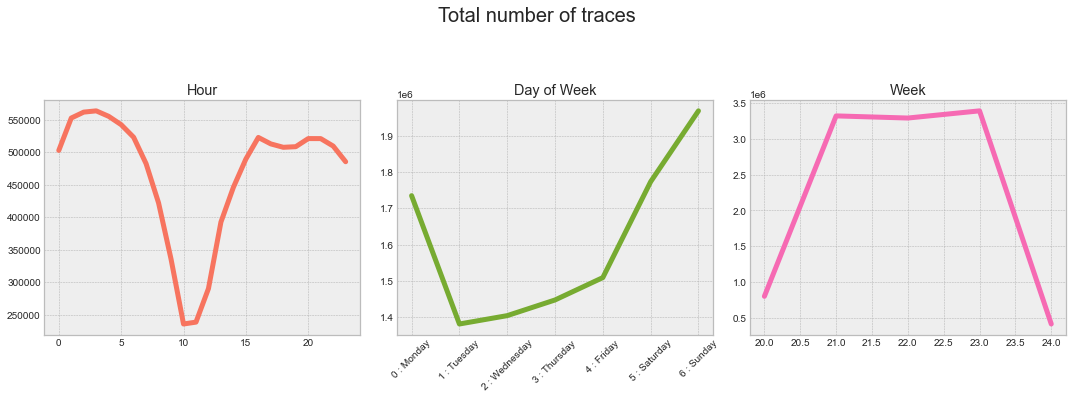

In [484]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

df.groupby('hour')['occupancy'].count() \
    .plot(kind='line',
          title='Hour',
          lw=5,
          color=color_pal[0],
          ax=ax1)

df.groupby('weekday')['occupancy'].count() \
    .plot(kind='line',
          title='Day of Week',
          lw=5,
          color=color_pal[1],
          ax=ax2)
ax2.tick_params(axis='x', rotation=45)

df.groupby('week')['occupancy'].count() \
    .plot(kind='line',
          lw=5,
          title='Week',
          color=color_pal[2],
          ax=ax3)

fig.suptitle('Total number of traces',
             size=20,
             y=1.1)

ax1.axes.xaxis.set_label_text('')
ax2.axes.xaxis.set_label_text('')
ax3.axes.xaxis.set_label_text('')

plt.tight_layout()
plt.show()

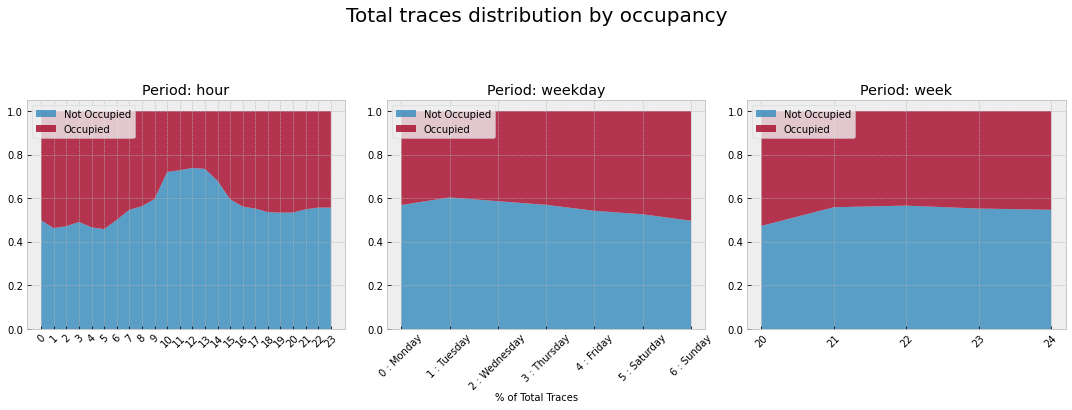

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    

for slice_level, ax_ in zip(['hour', 'weekday', 'week'], (ax1, ax2, ax3,)):
    data = calculatePercentage(df, slice_level=slice_level)
    ax_.stackplot(data[slice_level].astype(str).values,
          [data['Not Occupied'].values, data['Occupied'].values],
          labels= [ 'Not Occupied', 'Occupied' ],
          alpha=0.8
          )

    ax_.set_title(f'Period: {slice_level}')
    ax_.set_xticklabels(data[slice_level].astype(str).values, rotation=45)

fig.suptitle('Total traces distribution by occupancy',
             size=20,
             y=1.1)


ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')

fig.text(0.5, 0.005, '% of Total Traces', ha='center')
plt.tight_layout()
plt.show()

In [19]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15,5)})

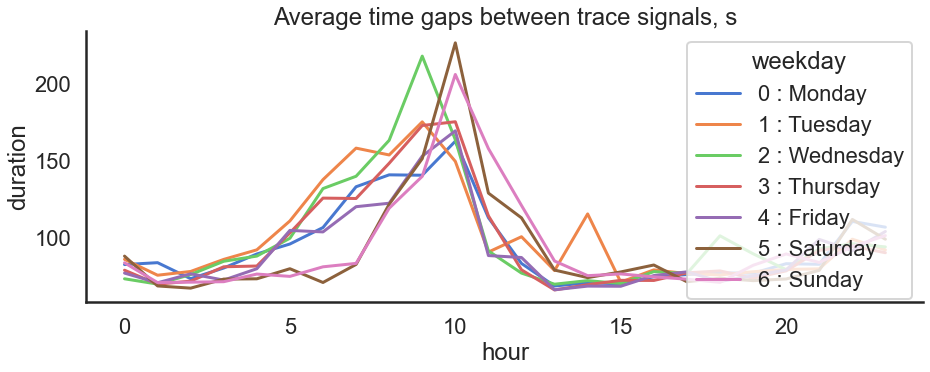

In [20]:
summary_hour_duration = pd.DataFrame(df.groupby(['weekday','hour'])['duration'].mean())

summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.lineplot(data=summary_hour_duration,
             x = "hour", y = "duration", 
             hue='weekday')
plt.title('Average time gaps between trace signals, s')
sns.despine(bottom = False)

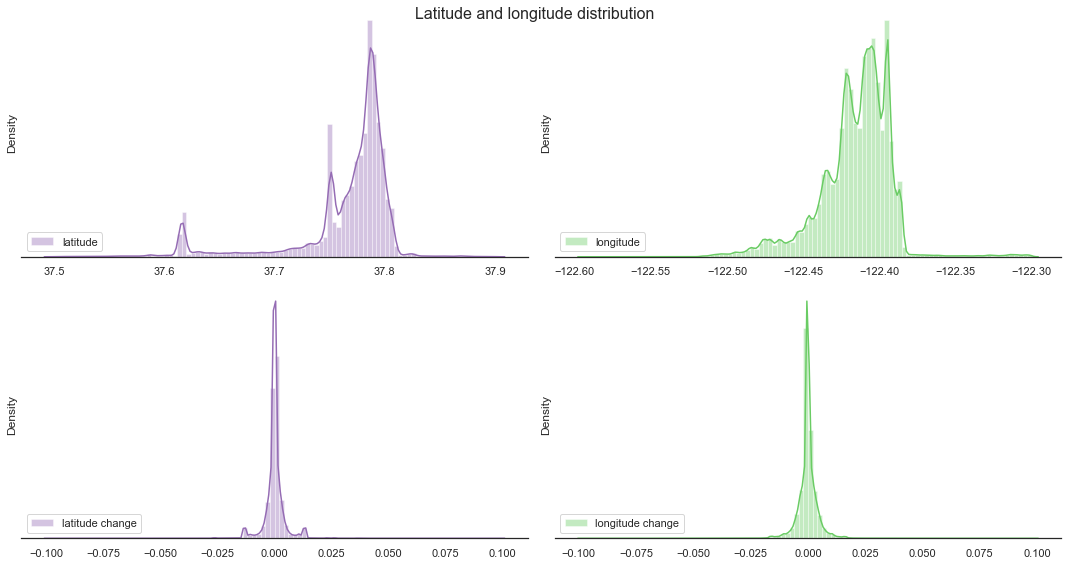

In [21]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(15, 8), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df[df['latitude'].between(37.5, 37.9)]['latitude'].sample(frac=0.1).values, 
             label = 'latitude',color="m",bins = 100, ax=axes[0, 0])
sns.distplot(df[df['longitude'].between(-122.6, -122.3)]['longitude'].sample(frac=0.1).values, 
             label = 'longitude',color="g",bins =100, ax=axes[0, 1])

sns.distplot(df[df['latitude_change'].between(-0.1, 0.1)]['latitude_change'].sample(frac=0.1).values, 
             label = 'latitude change',color="m",bins = 100, ax=axes[1, 0])
sns.distplot(df[df['longitude_change'].between(-0.1, 0.1)]['longitude_change'].sample(frac=0.1).values, 
             label = 'longitude change',color="g",bins =100, ax=axes[1, 1])

plt.setp(axes, yticks=[])
plt.tight_layout()
axes[0, 0].legend(loc='lower left')
axes[0, 1].legend(loc='lower left')
axes[1, 0].legend(loc='lower left')
axes[1, 1].legend(loc='lower left')
plt.suptitle('Latitude and longitude distribution')
plt.show()

## Data processing

Key assumptions
- trip is defined as a period with same sequential positive occupancy status
- there is always a break between trips thus we are excluding cases when next trips starts immediately after the previous one ends
- outliers ignored

In [23]:
df['changed_trip_status'] = ((df.occupancy != df.occupancy.shift(1)) & 
                              df.occupancy.shift(1).notnull())*1
df['trip_number'] = df.groupby(['filename'])['changed_trip_status'].cumsum()

df['trip_distance'] = \
    haversine(df.latitude, df.longitude,
              df.groupby('filename')['latitude'].shift(1), 
              df.groupby('filename')['longitude'].shift(1))

df['trip_distance'] = df.groupby(['filename', 'trip_number'])['trip_distance'].cumsum().fillna(0)

In [550]:
tripData = \
  df.groupby(['filename', 'trip_number', 'occupancy'])\
    .agg({'latitude' : ['min', 'max'],
           'longitude' : ['min', 'max'],
           'time' : ['min', 'max'],
           'trip_distance' : 'max'
          })\
    .reset_index()

In [551]:
df.shape[0], tripData.shape[0]

(11220058, 928307)

In [554]:
tripData.columns = ['filename', 'trip_number', 'occupancy', 'latitude_start',
                    'latitude_end', 'longitude_start', 'longitude_end', 
                    'start_time', 'end_time', 'trip_distance']

tripData['next_start_time'] = tripData.groupby(['filename', 'occupancy'])['start_time'].shift(2)
tripData['break_btw_trips'] = tripData['end_time'] - tripData['next_start_time']

tripData['next_latitude_start'] = tripData.groupby(['filename', 'occupancy'])['latitude_start'].shift(-1)
tripData['next_longitude_start'] = tripData.groupby(['filename', 'occupancy'])['longitude_start'].shift(-1)

tripData['latitude_start_to_start_delta'] = tripData['next_latitude_start']- tripData['latitude_start']
tripData['latitude_end_to_start_delta'] = tripData['next_latitude_start']- tripData['latitude_end']

tripData['longitude_start_to_start_delta'] = tripData['next_longitude_start']- tripData['longitude_start']
tripData['longitude_end_to_start_delta'] = tripData['next_longitude_start']- tripData['longitude_end']

# tripData['trip_distance'] = \
#     haversine(tripData.latitude_end, tripData.longitude_end,
#                  tripData.latitude_start, tripData.longitude_start)

In [555]:
tripData['trip_dutation_seconds'] = tripData['end_time'] - tripData['start_time']

## Additional EDA

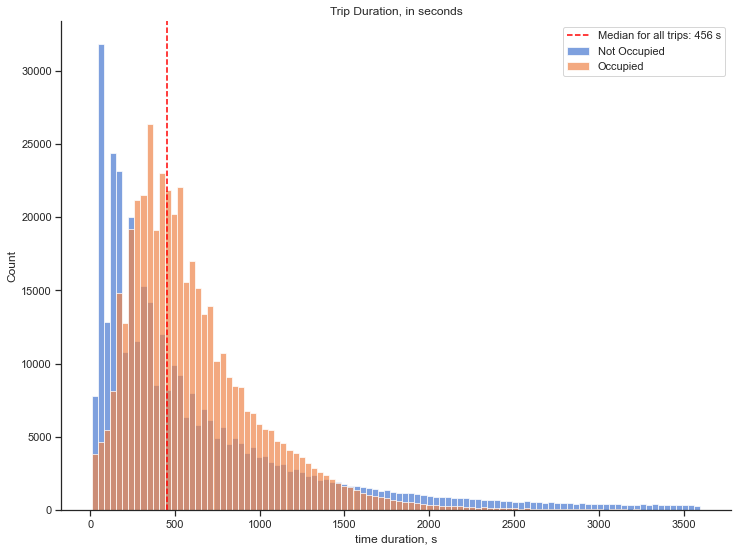

In [30]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("time duration, s")  
plt.ylabel("Count")  

plt.hist(tripData[tripData.trip_dutation_seconds.between(10, 3600) & 
                  (tripData.occupancy == 0)]['trip_dutation_seconds'], 
         bins=100, label = 'Not Occupied', alpha=0.7)  
plt.hist(tripData[tripData.trip_dutation_seconds.between(10, 3600) & 
                  (tripData.occupancy == 1)]['trip_dutation_seconds'], 
         bins=100, label = 'Occupied', alpha=0.7)  
plt.axvline(x=tripData['trip_dutation_seconds'].median(), 
            label='Median for all trips: {0:0.0f} s'.format(tripData['trip_dutation_seconds'].median()), 
            linestyle='--', c='red')
plt.title('Trip Duration, in seconds')
plt.legend()
plt.show()

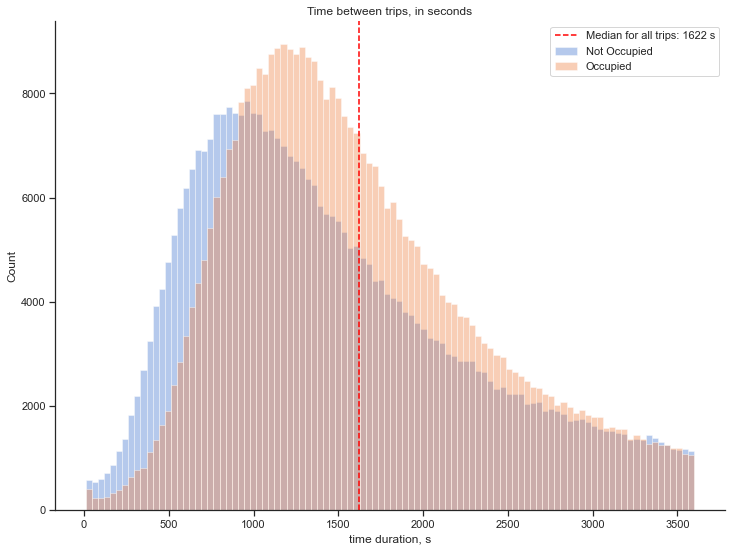

In [31]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("time duration, s")  
plt.ylabel("Count")  

plt.hist(tripData[tripData.break_btw_trips.between(10, 3600) & 
                  (tripData.occupancy == 0)]['break_btw_trips'], 
         bins=100, label = 'Not Occupied', alpha=0.4)  
plt.hist(tripData[tripData.break_btw_trips.between(10, 3600) & 
                  (tripData.occupancy == 1)]['break_btw_trips'], 
         bins=100, label = 'Occupied', alpha=0.4)  
plt.axvline(x=tripData['break_btw_trips'].median(), 
            label='Median for all trips: {0:0.0f} s'.format(tripData['break_btw_trips'].median()), 
            linestyle='--', c='red')
plt.title('Time between trips, in seconds')
plt.legend()
plt.show()

In [32]:
print('Mean + 2 sigma for time gaps btw trips, hours: {0:0.1f}'.format(
    (tripData[tripData.occupancy == 1]['break_btw_trips'].mean() + \
             2*tripData[tripData.occupancy == 1]['break_btw_trips'].std()) / 3600)
     )

Mean + 2 sigma for time gaps btw trips, hours: 5.2


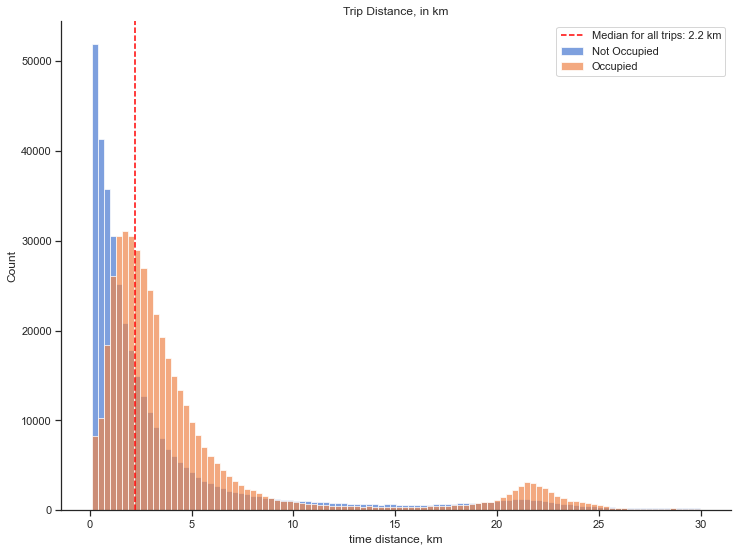

In [34]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("time distance, km")  
plt.ylabel("Count")  

plt.hist(tripData[tripData.trip_distance.between(0.1, 30) & 
                  (tripData.occupancy == 0)]['trip_distance'], 
         bins=100, label = 'Not Occupied', alpha=0.7)  
plt.hist(tripData[tripData.trip_distance.between(0.1, 30) & 
                  (tripData.occupancy == 1)]['trip_distance'], 
         bins=100, label = 'Occupied', alpha=0.7)  
plt.axvline(x=tripData['trip_distance'].median(), 
            label='Median for all trips: {0:0.1f} km'.format(tripData['trip_distance'].median()), 
            linestyle='--', c='red')
plt.title('Trip Distance, in km')
plt.legend()
plt.show()

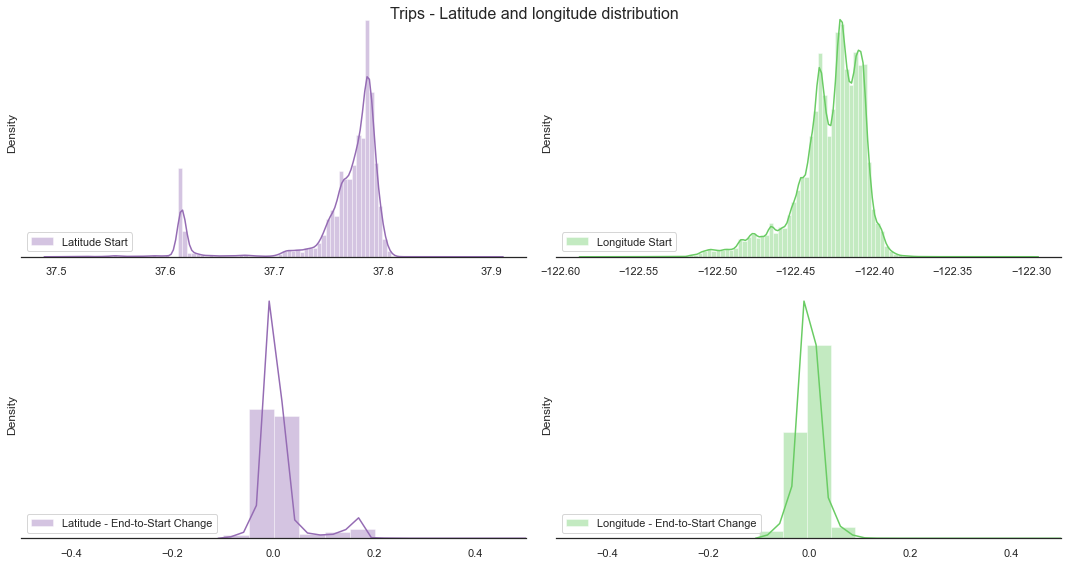

In [548]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(15, 8), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(tripData[tripData['latitude_start'].between(37.5, 37.9) & 
                      (tripData.occupancy == 1)]['latitude_start'].values, 
             label = 'Latitude Start',color="m",bins = 100, ax=axes[0, 0])
sns.distplot(tripData[tripData['longitude_start'].between(-122.6, -122.3) & 
                      (tripData.occupancy == 1)]['longitude_start'].values, 
             label = 'Longitude Start',color="g",bins =100, ax=axes[0, 1])

sns.distplot(tripData[tripData['latitude_end_to_start_delta'].between(-0.1, 0.1) & 
                      (tripData.occupancy == 1)]['latitude_start_to_start_delta'].values, 
             label = 'Latitude - End-to-Start Change',color="m",bins = 100, ax=axes[1, 0])
sns.distplot(tripData[tripData['longitude_end_to_start_delta'].between(-0.1, 0.1) & 
                      (tripData.occupancy == 1)]['longitude_start_to_start_delta'].values, 
             label = 'Longitude - End-to-Start Change',color="g",bins =100, ax=axes[1, 1])

plt.setp(axes, yticks=[])
plt.tight_layout()
axes[0, 0].legend(loc='lower left')
axes[0, 1].legend(loc='lower left')
axes[1, 0].legend(loc='lower left')
axes[1, 1].legend(loc='lower left')

axes[1, 0].set_xlim([-0.5, 0.5])
axes[1, 1].set_xlim([-0.5, 0.5])

plt.suptitle('Trips - Latitude and longitude distribution')
plt.show()

In [556]:
tripData['dt_start'] = pd.to_datetime(tripData['start_time'],unit='s')
tripData['dt_end'] = pd.to_datetime(tripData['end_time'],unit='s')

tripData['weekday_number_start'] = tripData['dt_start'].dt.weekday
tripData['weekday_name_start'] = tripData['dt_start'].dt.day_name()
tripData['weekday_start'] = tripData['weekday_number_start'].astype(str) + ' : ' + tripData['weekday_name_start']
tripData['hour_start'] = tripData['dt_start'].dt.hour
tripData['week_start'] = tripData['dt_start'].dt.isocalendar().week


tripData['weekday_number_end'] = tripData['dt_end'].dt.weekday
tripData['weekday_name_end'] = tripData['dt_end'].dt.day_name()
tripData['weekday_end'] = tripData['weekday_number_end'].astype(str) + ' : ' + tripData['weekday_name_end']
tripData['hour_end'] = tripData['dt_end'].dt.hour
tripData['week_end'] = tripData['dt_end'].dt.isocalendar().week

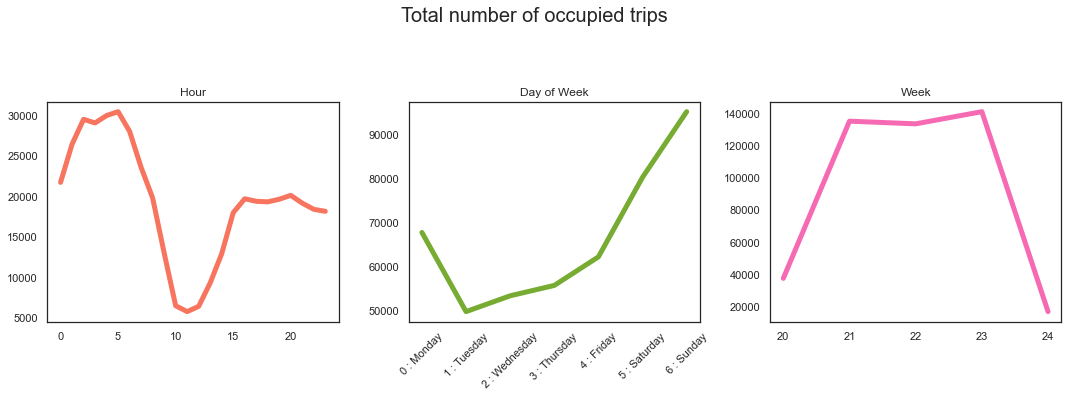

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

tripData.groupby('hour_start')['occupancy'].sum() \
    .plot(kind='line',
          title='Hour',
          lw=5,
          color=color_pal[0],
          ax=ax1)

tripData.groupby('weekday_start')['occupancy'].sum() \
    .plot(kind='line',
          title='Day of Week',
          lw=5,
          color=color_pal[1],
          ax=ax2)
ax2.tick_params(axis='x', rotation=45)

tripData.groupby('week_start')['occupancy'].sum() \
    .plot(kind='line',
          lw=5,
          title='Week',
          color=color_pal[2],
          ax=ax3)

fig.suptitle('Total number of occupied trips',
             size=20,
             y=1.1)
ax1.axes.xaxis.set_label_text('')
ax2.axes.xaxis.set_label_text('')
ax3.axes.xaxis.set_label_text('')

plt.tight_layout()
plt.show()

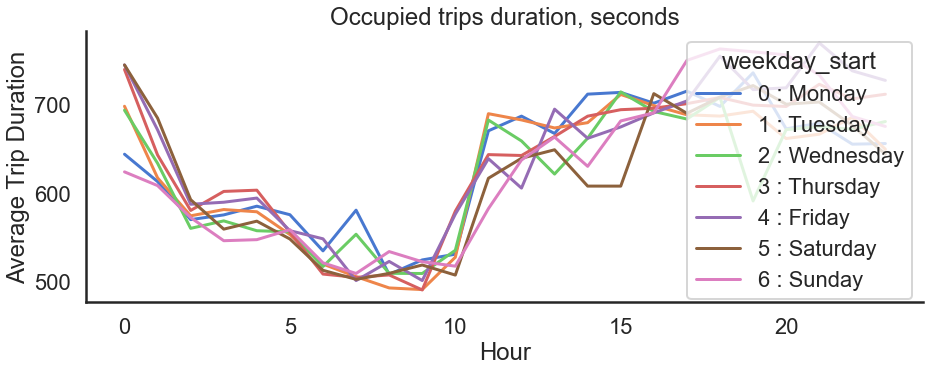

In [232]:
summary_hour_duration = \
    pd.DataFrame(tripData[tripData.occupancy == 1].groupby(['weekday_start','hour_start'])['trip_dutation_seconds'].mean())

summary_hour_duration.reset_index(inplace = True)
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.lineplot(data=summary_hour_duration,
             x = "hour_start", y = "trip_dutation_seconds", 
             hue='weekday_start')
plt.xlabel('Hour')
plt.ylabel('Average Trip Duration')
plt.title('Occupied trips duration, seconds')
sns.despine(bottom = False)

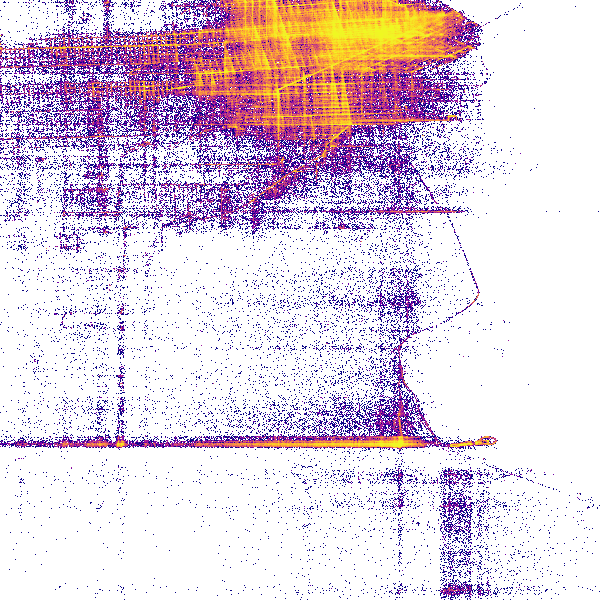

In [443]:
x_range = (-122.5, -122.36)
y_range = (37.55, 37.8)
background = "black"

scene = datashader.Canvas(plot_width=600, plot_height=600, x_range=x_range, y_range=y_range)
aggregation = scene.points(tripData, 'longitude_start', 'latitude_start')
image = datashader.transfer_functions.shade(aggregation, cmap=cm.plasma)
image

In [438]:
background = "black"
export = partial(export_image, export_path="export", background=background)
# cmaps = partial(colormap_select, reverse=(background=="black"))

In [440]:
output_notebook()
p = base_plot(background_fill_color=background)
export(create_image(x_range, y_range), "Trips")
InteractiveImage(p, create_image)

Loading BokehJS ...

# The potential for a yearly reduction in CO2 emissions

Monthly CO2 emission is forecasted as:

$$M_{t} = M_{t-1}\times GrowthRate\times (1-ReductionRate)$$

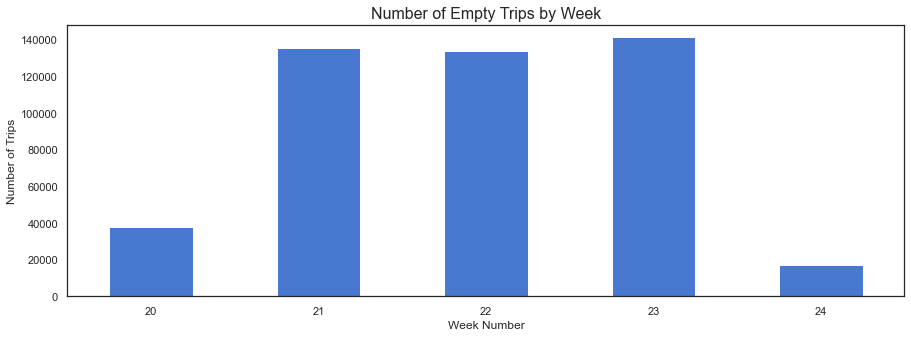

In [566]:
tripData[tripData.occupancy == 0].groupby('week_start')['weekday_start'].count().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('Number of Trips')
plt.xlabel('Week Number')
plt.title('Number of Empty Trips by Week', fontsize=16)
plt.show()

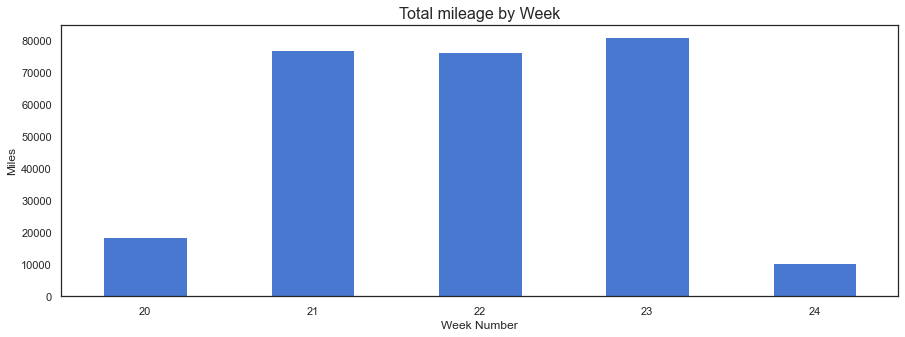

In [571]:
(tripData[(tripData.occupancy == 0) & 
         (tripData.break_btw_trips <= 3600) & \
         (tripData.trip_distance <= 30)
        ].groupby('week_start')['trip_distance'].sum()*0.621371).plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('Miles')
plt.xlabel('Week Number')
plt.title('Total mileage by Week', fontsize=16)
plt.show()

In [595]:
low_avg_weekly_miles_wo_passengers = \
tripData[(tripData.occupancy == 0) & 
         (tripData.week_start.isin([21, 22, 23])) & 
         (tripData.break_btw_trips <= 3600) & \
         (tripData.trip_distance <= 30)
        ].groupby('week_start')['trip_distance']\
.sum()\
.mean()*0.621371*4

high_avg_weekly_miles_wo_passengers = \
tripData[(tripData.occupancy == 0) & 
         (tripData.week_start.isin([21, 22, 23])) & 
         (tripData.break_btw_trips <= 5*3600) & \
         (tripData.trip_distance <= 30)
        ].groupby('week_start')['trip_distance']\
.sum()\
.mean()*0.621371*4

In [601]:
low_avg_weekly_miles_wo_passengers/4, high_avg_weekly_miles_wo_passengers/4

(77942.25919187808, 251470.2531179259)

In [596]:
low_avg_weekly_miles_wo_passengers/4, high_avg_weekly_miles_wo_passengers

(311769.0367675123, 1005881.0124717036)

In [597]:
co2_per_mile_grams = 404

In [598]:
# annual monthly increase in the number of taxis ~ 5% annually
## https://www.statista.com/statistics/943496/number-of-taxi-drivers-united-states/

In [606]:
growth_rate_low = 1.00
growth_rate_high = 1.01
reduction_rate = 0.15

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

low_reductions = []
high_reductions = []

def reduction_calculator(initial_consumption, 
                         grow_rate,
                         reduction_rate,
                         current_month=1, max_months=12):
    res = []
    if current_month <= max_months:
        this_consumption = initial_consumption*grow_rate*(1-reduction_rate)
        this_reduction = initial_consumption - this_consumption
        res = [this_reduction] + reduction_calculator(this_consumption, grow_rate, reduction_rate, 
                                        current_month+1
                                       )
        
    return res

low_reductions = reduction_calculator(low_avg_weekly_miles_wo_passengers,
                                      growth_rate_low,
                                      reduction_rate
                                     )

high_reductions = reduction_calculator(high_avg_weekly_miles_wo_passengers,
                                      growth_rate_high,
                                      reduction_rate
                                     )

co2_reduction = pd.DataFrame({'Month' : months,
                              'Low Forecast' : low_reductions,
                              'High Forecast' : high_reductions,
                             })

co2_reduction['Low Forecast'] = co2_per_mile_grams*co2_reduction['Low Forecast'].cumsum() / 10**6
co2_reduction['High Forecast'] = co2_per_mile_grams*co2_reduction['High Forecast'].cumsum() / 10**6
co2_reduction['Average Estimation'] = (co2_reduction['High Forecast'] + co2_reduction['Low Forecast']) / 2

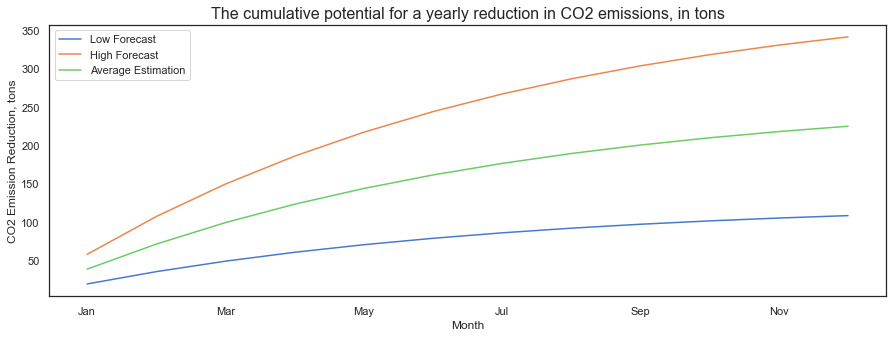

In [608]:
co2_reduction.plot(x='Month')
plt.ylabel('CO2 Emission Reduction, tons')
plt.title('The cumulative potential for a yearly reduction in CO2 emissions, in tons', fontsize=16)
plt.show()

# Features for ML predictor

Key assumptions:

- trip is a sequence of records with the same occupancy status
- shift is a sequence of records separated by more than 5 hours gap
- ML predicts a delta of two sequences with occupancy = 1 status separated by a sequence with occupancy status = 0

We have 2 targets:
- Longitude change between dropoff and pickup locations
- Latitude change between dropoff and pickup locations

In [159]:
tripData['shift_change'] = (tripData['break_btw_trips'] >= 3600*5)*1
tripData['shift_number'] = tripData.groupby(['filename'])['shift_change'].cumsum()
features = []

## Unique ID

In [160]:
tripData['trip_id'] = tripData['filename'].astype(str) + \
                      tripData['trip_number'].astype(str) + \
                      tripData['shift_number'].astype(str)
tripData['trip_day_id'] = tripData['filename'].astype(str) + \
                          tripData['shift_number'].astype(str)

## Previous Trips

In [161]:
list_of_features = ['latitude_start', 'latitude_end', 'longitude_start', 'longitude_end',
                    'dt_start', 'dt_end', 'break_btw_trips', 'trip_distance']

for feature in list_of_features:
    tripData[feature + '_previous_occupied_trip'] = \
        tripData.groupby('filename')[feature].shift(2)
    
    tripData[feature + '_previous_empty_trip'] = \
        tripData.groupby('filename')[feature].shift(1)
    
    features.extend([feature + '_previous_occupied_trip', 
                     feature + '_previous_empty_trip'])

In [162]:
features_base = ['latitude_start', 
                 'latitude_end', 
                 'longitude_start', 
                 'longitude_end']

features_compare = \
[
 'latitude_start_previous_occupied_trip',
 'latitude_start_previous_empty_trip',
 'latitude_end_previous_occupied_trip',
 'latitude_end_previous_empty_trip',
 'longitude_start_previous_occupied_trip',
 'longitude_start_previous_empty_trip',
 'longitude_end_previous_occupied_trip',
 'longitude_end_previous_empty_trip'
]

for feature_b in features_base:
    for feature_c in features_compare:
        tripData[feature_b + '_minus_' + feature_c] = \
            tripData[feature_b] - tripData[feature_c]
        features.append(feature_b + '_minus_' + feature_c)

In [163]:
features_base = ['dt_start', 'dt_end']

features_compare = \
[
 'dt_start_previous_occupied_trip',
 'dt_start_previous_empty_trip',
 'dt_end_previous_occupied_trip',
 'dt_end_previous_empty_trip'
]

for feature_b in features_base:
    for feature_c in features_compare:
        tripData[feature_b + '_minus_' + feature_c] = \
            (tripData[feature_b] - tripData[feature_c]).dt.seconds
        features.append(feature_b + '_minus_' + feature_c)

## Encoding of time features

In [164]:
from numpy import sin, cos, pi

In [165]:
def cyclic_encoding(df, col, max_val_mode='auto'):
    if max_val_mode == 'auto':
        max_val = df[col].max()
    else:
        if col == 'week':
            max_val = 52
        elif col == 'month':
            max_val = 12
        elif col == 'quarter':
            max_val = 4
        elif col == 'weekday':
            max_val = 7

    df[col + '_sin'] = sin(2 * pi * df[col].astype(float)/max_val)
    df[col + '_cos'] = cos(2 * pi * df[col].astype(float)/max_val)
    if col not in ['week', 'month', 'weekday']:
        return df.drop([col], axis=1)
    else:
        return df

In [166]:
tripData = cyclic_encoding(tripData, 'week_start')
tripData = cyclic_encoding(tripData, 'week_end')
tripData = cyclic_encoding(tripData, 'weekday_number_start')
tripData = cyclic_encoding(tripData, 'weekday_number_end')

## Driver

In [167]:
tripData['previous_empty_trip_distance'] = \
    tripData.groupby(['filename'])['trip_distance'].shift(1)

In [168]:
tripData['number_of_trip_by_driver_by_time'] = \
    tripData.groupby('trip_day_id')['trip_number'].cumsum()

In [169]:
columns = \
[
'latitude_start_minus_latitude_start_previous_occupied_trip', 
'latitude_start_minus_latitude_start_previous_empty_trip', 
'latitude_start_minus_latitude_end_previous_occupied_trip',
'latitude_start_minus_latitude_end_previous_empty_trip', 
'latitude_start_minus_longitude_start_previous_occupied_trip', 
'latitude_start_minus_longitude_start_previous_empty_trip', 
'latitude_start_minus_longitude_end_previous_occupied_trip', 
'latitude_start_minus_longitude_end_previous_empty_trip', 
'latitude_end_minus_latitude_start_previous_occupied_trip', 
'latitude_end_minus_latitude_start_previous_empty_trip', 
'latitude_end_minus_latitude_end_previous_occupied_trip', 
'latitude_end_minus_latitude_end_previous_empty_trip', 
'latitude_end_minus_longitude_start_previous_occupied_trip',
'latitude_end_minus_longitude_start_previous_empty_trip', 
'latitude_end_minus_longitude_end_previous_occupied_trip', 
'latitude_end_minus_longitude_end_previous_empty_trip', 
'longitude_start_minus_latitude_start_previous_occupied_trip', 
'longitude_start_minus_latitude_start_previous_empty_trip', 
'longitude_start_minus_latitude_end_previous_occupied_trip', 
'longitude_start_minus_latitude_end_previous_empty_trip', 
'longitude_start_minus_longitude_start_previous_occupied_trip', 
'longitude_start_minus_longitude_start_previous_empty_trip', 
'longitude_start_minus_longitude_end_previous_occupied_trip', 
'longitude_start_minus_longitude_end_previous_empty_trip', 
'longitude_end_minus_latitude_start_previous_occupied_trip', 
'longitude_end_minus_latitude_start_previous_empty_trip', 
'longitude_end_minus_latitude_end_previous_occupied_trip', 
'longitude_end_minus_latitude_end_previous_empty_trip', 
'longitude_end_minus_longitude_start_previous_occupied_trip',
'longitude_end_minus_longitude_start_previous_empty_trip', 
'longitude_end_minus_longitude_end_previous_occupied_trip', 
'longitude_end_minus_longitude_end_previous_empty_trip'
]

In [170]:
for column in columns:
    print(column)
    tripData[column + '_mean'] = \
        tripData.groupby('trip_day_id')[column].fillna(0).cumsum() / (tripData['number_of_trip_by_driver_by_time'] + 1e-6)

latitude_start_minus_latitude_start_previous_occupied_trip
latitude_start_minus_latitude_start_previous_empty_trip
latitude_start_minus_latitude_end_previous_occupied_trip
latitude_start_minus_latitude_end_previous_empty_trip
latitude_start_minus_longitude_start_previous_occupied_trip
latitude_start_minus_longitude_start_previous_empty_trip
latitude_start_minus_longitude_end_previous_occupied_trip
latitude_start_minus_longitude_end_previous_empty_trip
latitude_end_minus_latitude_start_previous_occupied_trip
latitude_end_minus_latitude_start_previous_empty_trip
latitude_end_minus_latitude_end_previous_occupied_trip
latitude_end_minus_latitude_end_previous_empty_trip
latitude_end_minus_longitude_start_previous_occupied_trip
latitude_end_minus_longitude_start_previous_empty_trip
latitude_end_minus_longitude_end_previous_occupied_trip
latitude_end_minus_longitude_end_previous_empty_trip
longitude_start_minus_latitude_start_previous_occupied_trip
longitude_start_minus_latitude_start_previou

In [171]:
tripData['trip_distance_mean_by_time'] = \
        tripData.groupby('trip_day_id')['trip_distance'].fillna(0).cumsum() / (tripData['number_of_trip_by_driver_by_time'] + 1-6)

In [172]:
tripData.head()

filename  trip_number  occupancy  latitude_start  latitude_end  longitude_start  longitude_end    start_time      end_time  trip_distance  next_start_time  break_btw_trips  next_latitude_start  next_longitude_start  latitude_start_to_start_delta  latitude_end_to_start_delta  longitude_start_to_start_delta  longitude_end_to_start_delta  trip_dutation_seconds            dt_start              dt_end weekday_name_start weekday_start  hour_start weekday_name_end   weekday_end  hour_end  shift_change  shift_number           trip_id      trip_day_id  latitude_start_previous_occupied_trip  latitude_start_previous_empty_trip  latitude_end_previous_occupied_trip  latitude_end_previous_empty_trip  longitude_start_previous_occupied_trip  longitude_start_previous_empty_trip  longitude_end_previous_occupied_trip  longitude_end_previous_empty_trip dt_start_previous_occupied_trip dt_start_previous_empty_trip dt_end_previous_occupied_trip dt_end_previous_empty_trip  \
0  new_abboip.txt            0        0.0        37.74978      37.75153       -122.39709     -122.39446  1.211034e+09  1.211036e+09       0.347694              NaN              NaN             37.75042            -122.42291                        0.00064                     -0.00111                        -0.02582                      -0.02845                 2314.0 2008-05-17 14:12:10 2008-05-17 14:50:44           Saturday  5 : Saturday          14         Saturday  5 : Saturday        14             0             0  new_abboip.txt00  new_abboip.txt0                                    NaN                                 NaN                                  NaN                               NaN                                     NaN                                  NaN                                   NaN                                NaN                             NaT                          NaT                           NaT                        NaT   
1  new_abboip.txt            1        1.0        37.74831      37.75552       -122.41438     -122.39724  1.211036e+09  1.211036e+09       2.246390              NaN              NaN             37.75053            -122.43101                        0.00222                     -0.00499                        -0.01663                      -0.03377                  288.0 2008-05-17 14:51:10 2008-05-17 14:55:58           Saturday  5 : Saturday          14         Saturday  5 : Saturday        14             0             0  new_abboip.txt10  new_abboip.txt0                                    NaN                            37.74978                                  NaN                          37.75153                                     NaN                           -122.39709                                   NaN                         -122.39446                             NaT          2008-05-17 14:12:10                           NaT        2008-05-17 14:50:44   
2  new_abboip.txt            2        0.0        37.75042      37.76523       -122.42291     -122.41441  1.211036e+09  1.211037e+09       3.578681              NaN              NaN             37.74833            -122.43172                       -0.00209                     -0.01690                        -0.00881                      -0.01731                 1315.0 2008-05-17 14:56:00 2008-05-17 15:17:55           Saturday  5 : Saturday          14         Saturday  5 : Saturday        15             0             0  new_abboip.txt20  new_abboip.txt0                               37.74978                            37.74831                             37.75153                          37.75552                              -122.39709                           -122.41438                            -122.39446                         -122.39724             2008-05-17 14:12:10          2008-05-17 14:51:10           2008-05-17 14:50:44        2008-05-17 14:55:58   
3  new_abboip.txt            3        1.0        37.75053      37.75206       -122.43101     -122.42086  1.21

# ML model

In [173]:
targets = ['latitude_end_to_start_delta', 'longitude_end_to_start_delta']

In [210]:
trainData.columns.tolist()

['index',
 'filename',
 'trip_number',
 'occupancy',
 'latitude_start',
 'latitude_end',
 'longitude_start',
 'longitude_end',
 'start_time',
 'end_time',
 'trip_distance',
 'next_start_time',
 'break_btw_trips',
 'next_latitude_start',
 'next_longitude_start',
 'latitude_start_to_start_delta',
 'latitude_end_to_start_delta',
 'longitude_start_to_start_delta',
 'longitude_end_to_start_delta',
 'trip_dutation_seconds',
 'dt_start',
 'dt_end',
 'weekday_name_start',
 'weekday_start',
 'hour_start',
 'weekday_name_end',
 'weekday_end',
 'hour_end',
 'shift_change',
 'shift_number',
 'trip_id',
 'trip_day_id',
 'latitude_start_previous_occupied_trip',
 'latitude_start_previous_empty_trip',
 'latitude_end_previous_occupied_trip',
 'latitude_end_previous_empty_trip',
 'longitude_start_previous_occupied_trip',
 'longitude_start_previous_empty_trip',
 'longitude_end_previous_occupied_trip',
 'longitude_end_previous_empty_trip',
 'dt_start_previous_occupied_trip',
 'dt_start_previous_empty_trip

In [252]:
features = \
[
'filename',
'latitude_start',
'latitude_end',
'longitude_start',
'longitude_end',
'hour_start',
'hour_end',
'trip_dutation_seconds',
'trip_distance',
'break_btw_trips',
'latitude_start_previous_occupied_trip',
'latitude_start_previous_empty_trip',
'latitude_end_previous_occupied_trip',
'latitude_end_previous_empty_trip',
'longitude_start_previous_occupied_trip',
'longitude_start_previous_empty_trip',
'longitude_end_previous_occupied_trip',
'longitude_end_previous_empty_trip',
'break_btw_trips_previous_occupied_trip',
'break_btw_trips_previous_empty_trip',
'trip_distance_previous_occupied_trip',
'trip_distance_previous_empty_trip',
'latitude_start_minus_latitude_start_previous_occupied_trip',
'latitude_start_minus_latitude_start_previous_empty_trip',
'latitude_start_minus_latitude_end_previous_occupied_trip',
'latitude_start_minus_latitude_end_previous_empty_trip',
'latitude_start_minus_longitude_start_previous_occupied_trip',
'latitude_start_minus_longitude_start_previous_empty_trip',
'latitude_start_minus_longitude_end_previous_occupied_trip',
'latitude_start_minus_longitude_end_previous_empty_trip',
'latitude_end_minus_latitude_start_previous_occupied_trip',
'latitude_end_minus_latitude_start_previous_empty_trip',
'latitude_end_minus_latitude_end_previous_occupied_trip',
'latitude_end_minus_latitude_end_previous_empty_trip',
'latitude_end_minus_longitude_start_previous_occupied_trip',
'latitude_end_minus_longitude_start_previous_empty_trip',
'latitude_end_minus_longitude_end_previous_occupied_trip',
'latitude_end_minus_longitude_end_previous_empty_trip',
'longitude_start_minus_latitude_start_previous_occupied_trip',
'longitude_start_minus_latitude_start_previous_empty_trip',
'longitude_start_minus_latitude_end_previous_occupied_trip',
'longitude_start_minus_latitude_end_previous_empty_trip',
'longitude_start_minus_longitude_start_previous_occupied_trip',
'longitude_start_minus_longitude_start_previous_empty_trip',
'longitude_start_minus_longitude_end_previous_occupied_trip',
'longitude_start_minus_longitude_end_previous_empty_trip',
'longitude_end_minus_latitude_start_previous_occupied_trip',
'longitude_end_minus_latitude_start_previous_empty_trip',
'longitude_end_minus_latitude_end_previous_occupied_trip',
'longitude_end_minus_latitude_end_previous_empty_trip',
'longitude_end_minus_longitude_start_previous_occupied_trip',
'longitude_end_minus_longitude_start_previous_empty_trip',
'longitude_end_minus_longitude_end_previous_occupied_trip',
'longitude_end_minus_longitude_end_previous_empty_trip',
'dt_start_minus_dt_start_previous_occupied_trip',
'dt_start_minus_dt_start_previous_empty_trip',
'dt_start_minus_dt_end_previous_occupied_trip',
'dt_start_minus_dt_end_previous_empty_trip',
'dt_end_minus_dt_start_previous_occupied_trip',
'dt_end_minus_dt_start_previous_empty_trip',
'dt_end_minus_dt_end_previous_occupied_trip',
'dt_end_minus_dt_end_previous_empty_trip',
'week_start_sin',
'week_start_cos',
'week_end_sin',
'week_end_cos',
'weekday_number_start_sin',
'weekday_number_start_cos',
'weekday_number_end_sin',
'weekday_number_end_cos',
'previous_empty_trip_distance',
'number_of_trip_by_driver_by_time',
'latitude_start_minus_latitude_start_previous_occupied_trip_mean',
'latitude_start_minus_latitude_start_previous_empty_trip_mean',
'latitude_start_minus_latitude_end_previous_occupied_trip_mean',
'latitude_start_minus_latitude_end_previous_empty_trip_mean',
'latitude_start_minus_longitude_start_previous_occupied_trip_mean',
'latitude_start_minus_longitude_start_previous_empty_trip_mean',
'latitude_start_minus_longitude_end_previous_occupied_trip_mean',
'latitude_start_minus_longitude_end_previous_empty_trip_mean',
'latitude_end_minus_latitude_start_previous_occupied_trip_mean',
'latitude_end_minus_latitude_start_previous_empty_trip_mean',
'latitude_end_minus_latitude_end_previous_occupied_trip_mean',
'latitude_end_minus_latitude_end_previous_empty_trip_mean',
'latitude_end_minus_longitude_start_previous_occupied_trip_mean',
'latitude_end_minus_longitude_start_previous_empty_trip_mean',
'latitude_end_minus_longitude_end_previous_occupied_trip_mean',
'latitude_end_minus_longitude_end_previous_empty_trip_mean',
'longitude_start_minus_latitude_start_previous_occupied_trip_mean',
'longitude_start_minus_latitude_start_previous_empty_trip_mean',
'longitude_start_minus_latitude_end_previous_occupied_trip_mean',
'longitude_start_minus_latitude_end_previous_empty_trip_mean',
'longitude_start_minus_longitude_start_previous_occupied_trip_mean',
'longitude_start_minus_longitude_start_previous_empty_trip_mean',
'longitude_start_minus_longitude_end_previous_occupied_trip_mean',
'longitude_start_minus_longitude_end_previous_empty_trip_mean',
'longitude_end_minus_latitude_start_previous_occupied_trip_mean',
'longitude_end_minus_latitude_start_previous_empty_trip_mean',
'longitude_end_minus_latitude_end_previous_occupied_trip_mean',
'longitude_end_minus_latitude_end_previous_empty_trip_mean',
'longitude_end_minus_longitude_start_previous_occupied_trip_mean',
'longitude_end_minus_longitude_start_previous_empty_trip_mean',
'longitude_end_minus_longitude_end_previous_occupied_trip_mean',
'longitude_end_minus_longitude_end_previous_empty_trip_mean',
'trip_distance_mean_by_time'
    
]

In [253]:
assert len(set(features)) == len(features)

In [251]:
trainData = tripData[(tripData.occupancy == 1) & 
                     (tripData.dt_start.dt.date < datetime.date(2008, 6, 6)) & 
                     (tripData.trip_dutation_seconds <= 3600) &
                     (tripData.trip_distance <= 30) &
                     (tripData.trip_distance_previous_empty_trip <= 50)
                    ].sample(frac=1, random_state=0).reset_index()

evalData = tripData[(tripData.occupancy == 1) & 
                    (tripData.dt_start.dt.date.between(datetime.date(2008, 6, 6),
                                                        datetime.date(2008, 6, 8)
                                                       )) & 
                     (tripData.trip_dutation_seconds <= 3600) &
                     (tripData.trip_distance <= 30) &
                     (tripData.trip_distance_previous_empty_trip <= 50)
                    ].reset_index()

testData = tripData[(tripData.occupancy == 1) & 
                    (tripData.dt_start.dt.date > datetime.date(2008, 6, 8)) & 
                    (tripData.trip_dutation_seconds <= 3600) &
                     (tripData.trip_distance <= 30) &
                     (tripData.trip_distance_previous_empty_trip <= 50)
                    ].reset_index()

In [614]:
tripData.dt_start.dt.date.min(), tripData.dt_start.dt.date.max()

(datetime.date(2008, 5, 17), datetime.date(2008, 6, 10))

In [254]:
cat_cols = []
enc_cols = []
for feature in features:
    if testData[feature].dtype == 'object':
        cat_cols.append(feature)

In [255]:
te_cv = TargetEncoderCV(KFold(n_splits=3))

for c in cat_cols:
    trainData[c + '_tenc'] = np.nan
    evalData[c + '_tenc'] = np.nan
    testData[c + '_tenc'] = np.nan
    enc_cols.append(c + '_tenc')
    
features = [
    c + '_tenc' if c in cat_cols else c for c in features]

trainData[enc_cols] = te_cv.fit_transform(
    trainData[cat_cols], trainData[targets[0]])
evalData[enc_cols] = te_cv.transform(evalData[cat_cols])
testData[enc_cols] = te_cv.transform(testData[cat_cols])

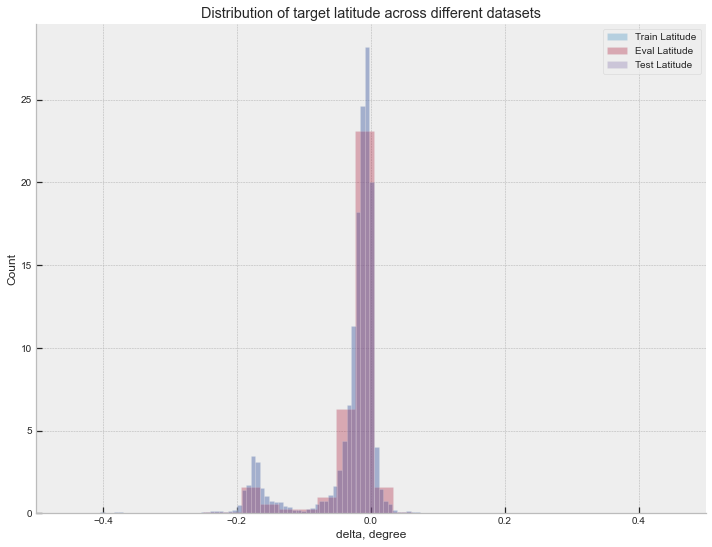

In [239]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("delta, degree")  
plt.ylabel("Count")  

plt.hist(testData['latitude_end_to_start_delta'], 
         bins=100, label = 'Train Latitude', alpha=0.3, density=True)
plt.hist(evalData['latitude_end_to_start_delta'], 
         bins=100, label = 'Eval Latitude', alpha=0.3, density=True)
plt.hist(testData['latitude_end_to_start_delta'], 
         bins=100, label = 'Test Latitude', alpha=0.3, density=True)
plt.title('Distribution of target latitude across different datasets')
plt.xlim([-0.5, 0.5])
plt.legend()
plt.show()

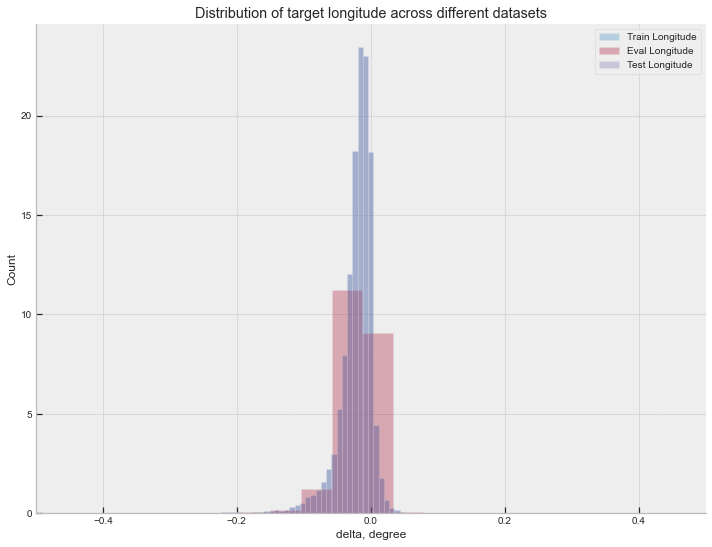

In [266]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("delta, degree")  
plt.ylabel("Count")  

plt.hist(testData['longitude_end_to_start_delta'], 
         bins=100, label = 'Train Longitude', alpha=0.3, density=True)
plt.hist(evalData['longitude_end_to_start_delta'], 
         bins=100, label = 'Eval Longitude', alpha=0.3, density=True)
plt.hist(testData['longitude_end_to_start_delta'], 
         bins=100, label = 'Test Longitude', alpha=0.3, density=True)
plt.title('Distribution of target longitude across different datasets')
plt.xlim([-0.5, 0.5])
plt.legend()
plt.show()

In [249]:
print('Training sampes: {}, Evaluation samples: {}, Test samples: {}'.format(
    trainData.shape[0], evalData.shape[0], testData.shape[0]))

Training sampes: 371497, Evaluation samples: 67510, Test samples: 16523


In [304]:
models = {}
params = {
        'max_bin': [128],
        'max_depth': [8],
        'num_leaves': [50],
        'reg_alpha': [0.15],
        'reg_lambda': [0.15],
        'min_data_in_leaf': [10],
        'learning_rate': [0.01]
        }

for target in targets:
    model = LGBMRegressor(n_estimators=10**5, n_jobs=-1, **params)
    model.fit(trainData[features], trainData[target],
              eval_set=(evalData[features], evalData[target]),
              eval_metric='rmse',
              verbose=100,
              early_stopping_rounds=10)
    models[target] = model

[100]	valid_0's rmse: 0.0468519	valid_0's l2: 0.0021951
[200]	valid_0's rmse: 0.0460674	valid_0's l2: 0.0021222
[300]	valid_0's rmse: 0.0458109	valid_0's l2: 0.00209864
[400]	valid_0's rmse: 0.045723	valid_0's l2: 0.00209059
[500]	valid_0's rmse: 0.045677	valid_0's l2: 0.00208638
[600]	valid_0's rmse: 0.0456485	valid_0's l2: 0.00208379
[700]	valid_0's rmse: 0.0456309	valid_0's l2: 0.00208218
[100]	valid_0's rmse: 0.0298277	valid_0's l2: 0.000889689
[200]	valid_0's rmse: 0.0291354	valid_0's l2: 0.00084887
[300]	valid_0's rmse: 0.0290047	valid_0's l2: 0.00084127
[400]	valid_0's rmse: 0.0289696	valid_0's l2: 0.000839238
[500]	valid_0's rmse: 0.0289591	valid_0's l2: 0.000838628


In [305]:
testData['predicted_latitude_start_delta'] = \
    models['latitude_end_to_start_delta'].predict(testData[features])

testData['predicted_longitude_start_delta'] = \
    models['longitude_end_to_start_delta'].predict(testData[features])

In [306]:
testData['predicted_latitude_start_error'] = \
    testData['predicted_latitude_start_delta'] - testData['latitude_end_to_start_delta']

testData['predicted_longitude_start_error'] = \
    testData['predicted_longitude_start_delta'] - testData['longitude_end_to_start_delta']

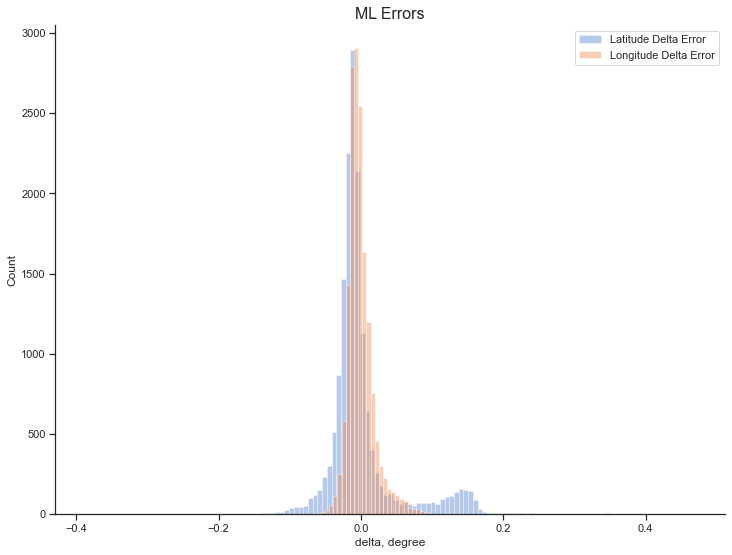

In [610]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("delta, degree")  
plt.ylabel("Count")  

plt.hist(testData['predicted_latitude_start_error'], 
         bins=100, label = 'Latitude Delta Error', alpha=0.4)  
plt.hist(testData['predicted_longitude_start_error'], 
         bins=100, label = 'Longitude Delta Error', alpha=0.4)  
plt.title('ML Errors', fontsize=16)
plt.legend()
plt.show()

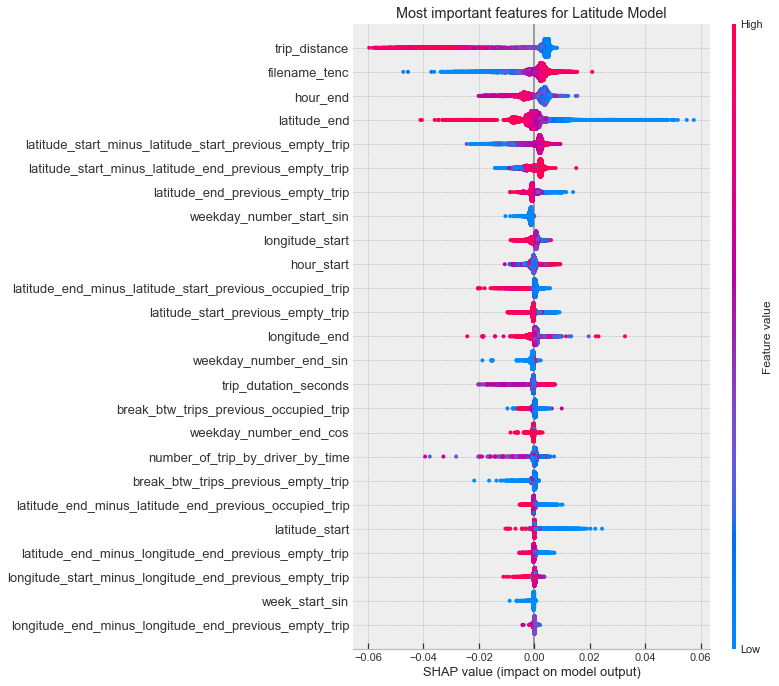

In [348]:
explainer = shap.TreeExplainer(models['latitude_end_to_start_delta'])
shap_values = explainer(testData[features])

shap.summary_plot(
    explainer(testData[features]),
    max_display=25,
    show=False
)

plt.title('Most important features for Latitude Model')
plt.show()

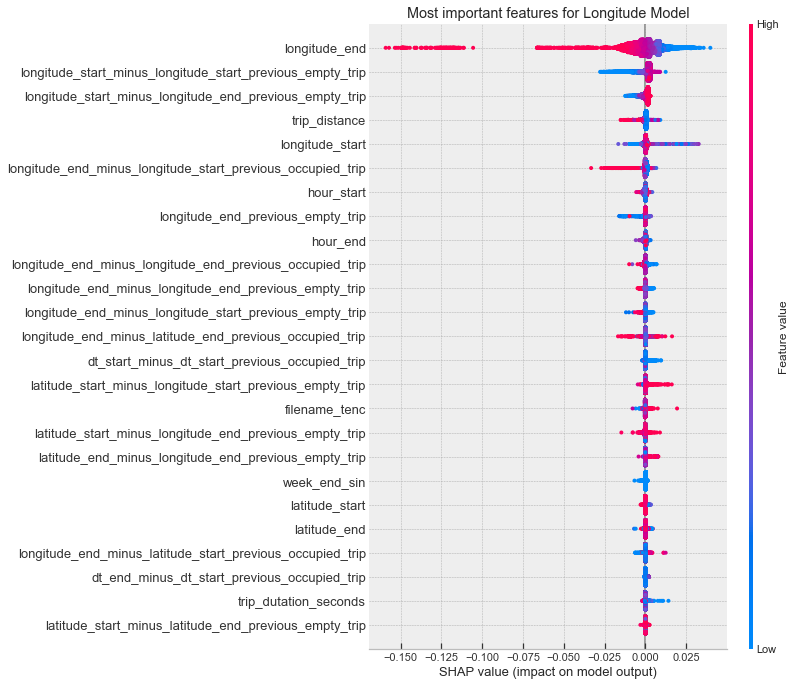

In [349]:
explainer = shap.TreeExplainer(models['longitude_end_to_start_delta'])
shap_values = explainer(testData[features])

shap.summary_plot(
    explainer(testData[features]),
    max_display=25,
    show=False
)

plt.title('Most important features for Longitude Model')
plt.show()

# Naive impact evaluation

In [421]:
testData['predicted_latitude_start'] = testData['predicted_latitude_start_delta'] + \
                                       testData['latitude_end']
testData['predicted_longitude_start'] = 0.5*testData['predicted_longitude_start_delta'] + \
                                       testData['longitude_end']

In [422]:
testData['distance_btw_trips'] = \
        haversine(testData.latitude_end, testData.longitude_end,
                 testData.next_latitude_start, testData.next_longitude_start)

In [423]:
testData['ml_error_trip'] = \
    haversine(testData.latitude_end, testData.longitude_end,
                 testData.predicted_latitude_start, testData.predicted_longitude_start)

In [429]:
testData['ml_error_in_km'] = \
    0.5*haversine(testData.latitude_end, testData.longitude_end,
                 testData.predicted_latitude_start, testData.predicted_longitude_start) + \
    0.5*haversine(testData.next_latitude_start, testData.next_longitude_start,
                 testData.predicted_latitude_start, testData.predicted_longitude_start)

In [438]:
testData.trip_distance_previous_empty_trip.sum(), testData['ml_error_in_km'].sum()

(69487.4490056532, 64301.84733927558)

In [482]:
print('Potential empty mileage reduction: {0:0.1%}'.format(
(1 - testData['ml_error_in_km'].sum() / testData.trip_distance_previous_empty_trip.sum())))

Potential empty mileage reduction: 7.5%


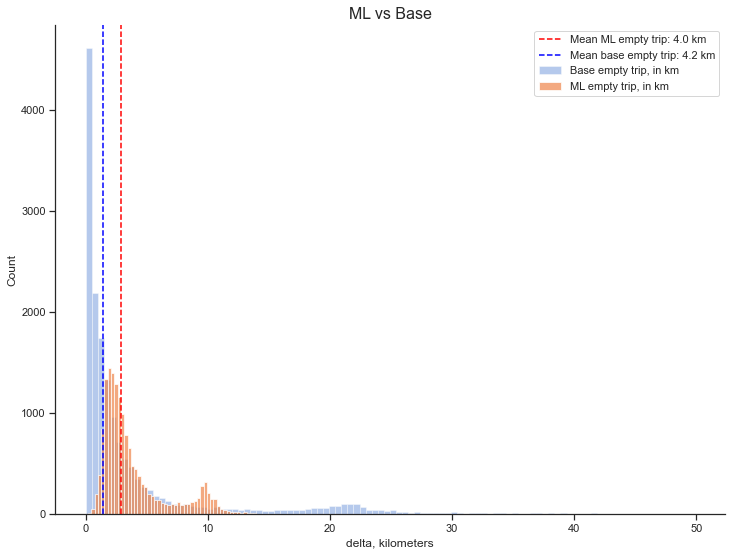

In [613]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("delta, kilometers")  
plt.ylabel("Count")  

plt.hist(testData['trip_distance_previous_empty_trip'], 
         bins=100, label = 'Base empty trip, in km', alpha=0.4)  
plt.hist(testData['ml_error_in_km'], 
         bins=100, label = 'ML empty trip, in km', alpha=0.7)  

plt.axvline(x=testData['ml_error_in_km'].median(), 
            label='Mean ML empty trip: {0:0.1f} km'.format(testData['ml_error_in_km'].mean()), 
            linestyle='--', c='red')

plt.axvline(x=testData['trip_distance_previous_empty_trip'].median(), 
            label='Mean base empty trip: {0:0.1f} km'.format(testData['trip_distance_previous_empty_trip'].mean()), 
            linestyle='--', c='blue')

plt.title('ML vs Base', fontsize=16)
plt.legend()
plt.show()

# Clustering drivers

In [487]:
from sklearn.cluster import KMeans

In [629]:
clusters = \
    tripData.groupby(['filename', 'latitude_start', 'latitude_end', 'longitude_start', 'longitude_end'])['occupancy'].sum()\
    .reset_index()

In [630]:
clusters.shape

(927266, 6)

In [631]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(clusters.iloc[:, 1:])

In [632]:
clusters['cluster'] = kmeans.labels_

In [634]:
# (clusters['cluster'].value_counts() / clusters.shape[0])[::-1].plot(kind='barh', figsize=(7,5))
# plt.xlabel('% of points')
# plt.ylabel('Cluster Name')
# plt.title('Percentage of points by each cluster', fontsize=16)
# plt.show()

In [518]:
clusters['color'] = clusters['cluster'].map(lambda x: color_pal[x+2])

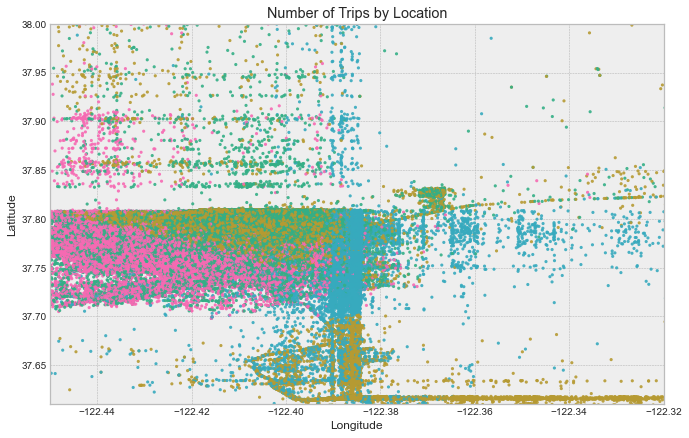

In [519]:
fig, ax = plt.subplots(figsize=(11, 7))
plt.scatter(clusters['longitude_end'], clusters['latitude_end'], 
c=clusters['color'], alpha=0.9, s=10, edgecolor='none')
ax.set_ylim([37.61, 
             38.0])
ax.set_xlim([-122.45, 
             -122.32])
plt.title('Number of Trips by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [530]:
gr = clusters.groupby(['filename', 'cluster'])['occupancy'].sum().reset_index()
# gr = pd.pivot_table(clusters,
#                     index='filename',
#                     columns='cluster',
#                     values='occupancy',
#                     aggfunc='sum'
#                    ).fillna(0).reset_index()

In [531]:
gr['occupancy_share'] = gr['occupancy'] / gr['filename'].map(gr.groupby('filename')['occupancy'].sum().to_dict())

In [537]:
gr['rank'] = gr.groupby('filename')['occupancy_share'].rank(ascending=False)

In [538]:
gr.head()

filename  cluster  occupancy  occupancy_share  rank
0  new_abboip.txt        0        0.0         0.000000   4.0
1  new_abboip.txt        1        3.0         0.003135   3.0
2  new_abboip.txt        2      893.0         0.933124   1.0
3  new_abboip.txt        3       61.0         0.063741   2.0
4  new_abcoij.txt        0        0.0         0.000000   2.5

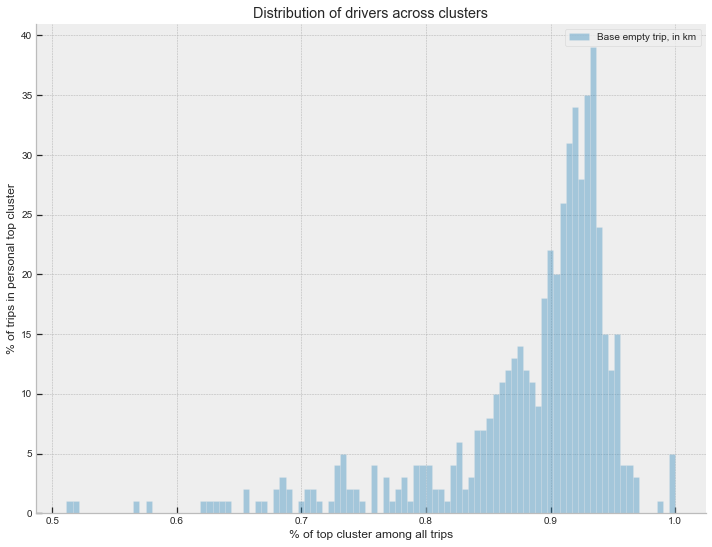

In [542]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("% of top cluster among all trips")  
plt.ylabel("% of trips in personal top cluster")  

plt.hist(gr[gr['rank'] == 1]['occupancy_share'], 
         bins=100, label = 'Base empty trip, in km', alpha=0.4)  

plt.title('Distribution of drivers across clusters')
plt.legend()
plt.show()